In [1]:
from smt_network_model import Sender, AbstractSMTNetworkModel

%matplotlib inline
import matplotlib.ticker as mticks
import matplotlib.pyplot as plt

import numpy as np
from z3 import *
set_param('parallel.enable', True)
set_param('parallel.threads.max', 8)

# Description
A model that keeps track of the cumulative number of bytes (in/out/lost) until timestep $t$. Each propagation delay is divided into a certain number of timesteps

Here, we do not keep track of where every packet is in the buffer, which will hopefully make things run faster since there are fewer variables (but a similar number of constraints to keep track of the buffer).

The loss model is that if the queue is large enough (according to our dynamic threshold), the sender gets to non-deterministically choose to not accept packets. 

# Parameters

## Sender-Level
* $R$ - propagation delay (in timesteps)
* $T$ - number of timesteps we simulate (assumed divisible by $R$)
* $C$ - the server's transmission rate (in pkts/timestep)
* $CCA$ - The congestion control algorithm we'll use

## Global-level
* $Lmax$ - maximum number of packets in the buffer. It needs to be finite so there are fewer constraints for the SMT solver (otherwise constraints will increase that's all)
* $Lmin$ - minimum buffer size that the non-deterministic server can emulate (Lmin >= 1)
* $D$ - the slack parameter (different from v1!)

G
# Variables
* $out_t$ - Number of packets output from server till time $t$
* $inp_t$ - Number of packets that have been accepted into the buffer till time $t$
* $lost_t$ - Number of packets lost till time $t$
* $Ku_t, Kl_t$ - upper and lower slack. Can change if the server decides to waste transmission opportunities

* $cwnd_t$ - cwnd at the beginning of timestep $t$
* $rate_t$ - rate (in pkts / RTT) at during timestep $t$ (i.e. in $[t-1, t)$)

* $loss\_detected_t$ - pkt loss detected at time $t$
* $qdel_t$ - queuing delay measured at time $t$

# Constraints
* $\min(inp_t, C t - Kl_t) \le out_t \le C t + Ku_t$ $\Rightarrow \min(inp_t / C, t - Kl_t / C) \le out_t / C \le t + Ku_t / C$
* $C(t + D) - Kl_{t + D} =Ct + Ku_t$.
* Maximum queuing delay is $D + \frac{L}{C}$.


In [2]:
class SMTNetworkModelV2(AbstractSMTNetworkModel):
    def __init__(self):
        super().__init__()

    def add_flow_constraints_for_sender(self, sender_id):
        # Copy off variables, to make the equations much neater.
        sender = self.get_sender(sender_id)
        CCA, out, inp, lost, Ku, Kl, dupacks, C, R, T, cwnd, rate, lost_detected, last_cwnd_decr = sender.CCA, sender.out, sender.inp, sender.lost, sender.Ku, sender.Kl, sender.dupacks, sender.C, sender.R, sender.T, sender.cwnd, sender.rate, sender.lost_detected, sender.last_cwnd_decr
        D, Lmin, Lmax = self.D, self.Lmin, self.Lmax

        C_inv = int(1. / C)
        for t in range(1, T):
            # All are monotonic.
            self.add_constr(out[t] >= out[t-1])
            self.add_constr(lost[t] >= lost[t-1])
            self.add_constr(inp[t] >= inp[t-1])

            # Constrain the out[t] / C between the 'black' lines.
            self.add_constr(t - Kl[t] * C_inv <= out[t] * C_inv)
            self.add_constr(t + Ku[t] * C_inv >= out[t] * C_inv)

            # Output is bounded above by input.
            self.add_constr(inp[t] >= out[t])

            # Determine if we can waste transmissions
            if t == 1:
                # Disallow waste on the first timestep, since that makes the results a bit different from steady state results
                waste_allowed = False
            else:
                waste_allowed = C*t + Ku[t] >= inp[t-1]
            self.add_constr(Implies(waste_allowed,
                          And(Ku[t] <= Ku[t-1])))
            self.add_constr(Implies(Not(waste_allowed),
                          And(Ku[t] == Ku[t-1],
                              Kl[t] == Kl[t-1])))

            # Constraint between the parallel 'black' lines.
            if t + D < T:
                self.add_constr((t + D) - Kl[(t + D)] * C_inv == t + Ku[t] * C_inv)

            # Ensure the 'black' lines don't go below 0.
            self.add_constr(t - Kl[t] * C_inv >= 0)
            self.add_constr(t + Ku[t] * C_inv >= 0)

            # Outputs, windows and rates together decide how input changes
            # Previously total number of packets from the sender
            prev = inp[t-1] + lost[t-1]

            # Input due to rate
            next_r = prev + rate[t]
            # Input due to window
            if t >= R:
                next_w_tmp = out[t-R] + lost_detected[t-R] + cwnd[t]
                next_w = If(next_w_tmp > prev, next_w_tmp, prev)
            else:
                next_w = cwnd[t]
            # Min of window and rate above two
            self.add_constr(inp[t] + lost[t] == If(next_w < next_r, next_w, next_r))

            # If queue length is below threshold, loss isn't allowed
            can_lose = inp[t-1] >= C*(t - 1) + Ku[t - 1] + Lmin
            self.add_constr(Implies(Not(can_lose),
                            lost[t] == lost[t-1]))

            # If we're above the green line, we can only drop upto the green line.
            self.add_constr(Implies(can_lose,
                            inp[t] >= C*t + Ku[t] + Lmin))

        ## Loss detection logic
        # If any variable is true in loss_vars[t], loss_detected[t] is true
        loss_vars = [[] for _ in range(T)]
        for t in range(1, T):
            for dt in range(1, int(D + (Lmax) / C + 1.)):
                if t + R + dt >= T:
                    break
                loss_vars[t + R + dt].append(
                    If(And(inp[t] + dupacks <= out[t + dt],
                           inp[t] + dupacks > out[t + dt - 1]),
                       lost[t] - lost[t-1],
                       0))
        for t in range(1, T):
            if len(loss_vars[t]) > 0:
                self.add_constr(lost_detected[t] == lost_detected[t-1] + Sum(*loss_vars[t]))
            else:
                self.add_constr(lost_detected[t] == lost_detected[t-1])

    def add_congestion_control_for_sender(self, sender_id):
        # Copy off variables, to make the equations much neater.
        sender = self.get_sender(sender_id)
        CCA, out, inp, lost, Ku, Kl, dupacks, C, R, T, cwnd, rate, lost_detected, last_cwnd_decr = sender.CCA, sender.out, sender.inp, sender.lost, sender.Ku, sender.Kl, sender.dupacks, sender.C, sender.R, sender.T, sender.cwnd, sender.rate, sender.lost_detected, sender.last_cwnd_decr
        D, Lmin, Lmax = self.D, self.Lmin, self.Lmax
    
        for t in range(1, T):
            # Enable exactly one of the following!
            if CCA == "const":
                # Constant
                self.add_constr(rate[t] == rate[t-1])
                self.add_constr(cwnd[t] == cwnd[t-1])
            elif CCA == "AIMD":
                # AIMD
                # If there was a loss previously within a min RTT, we won't 
                # decrease now even if there is a loss
                if t >= R + 1:
                    # The -1 is important otherwise we will again reduce for 
                    # a loss that happened *before* the last loss. This is 
                    # because 
                    prev_loss = last_cwnd_decr[t-1] >= out[t - R - 1]
                else:
                    prev_loss = False

                # Whether we should decrease cwnd
                decrease = And(lost_detected[t] > lost_detected[t-1], Not(prev_loss))

                # Increase/decrease window as appropriate
                self.add_constr(Implies(Not(decrease),
                              cwnd[t] == cwnd[t-1] + 1. / R))
                self.add_constr(Implies(decrease,
                              cwnd[t] == cwnd[t-1] / 2.))
                # Infinite rate - basically, a burst of packets.
                self.add_constr(rate[t] == C * 10)

                # Keep last_cwnd_decr
                self.add_constr(Implies(Not(decrease),
                                last_cwnd_decr[t] == last_cwnd_decr[t-1]))
                # WARNING: We add + C here to account for extra flexibility 
                # allowed by the SMT relaxation of the original constraints.
                # Haven't thought through this fully
                self.add_constr(Implies(decrease,
                              last_cwnd_decr[t] == inp[t]))
            else:
                raise ValueError("Unrecognized CCA: '%s'" % CCA)

    def add_initial_constraints_for_sender(self, sender_id):
        sender = self.get_sender(sender_id)
        CCA, out, inp, lost, Ku, Kl, dupacks, C, R, T, cwnd, rate, lost_detected, last_cwnd_decr = sender.CCA, sender.out, sender.inp, sender.lost, sender.Ku, sender.Kl, sender.dupacks, sender.C, sender.R, sender.T, sender.cwnd, sender.rate, sender.lost_detected, sender.last_cwnd_decr
        D, Lmin, Lmax = self.D, self.Lmin, self.Lmax

        self.add_constr(out[0] == 0)
        self.add_constr(inp[0] == 0)
        self.add_constr(lost[0] == 0)
        self.add_constr(lost_detected[0] == 0)
        self.add_constr(last_cwnd_decr[0] == 0)
        self.add_constr(Ku[0] == 0)
        self.add_constr(Kl[D] == C*D)
        self.add_constr(rate[0] == 1)
        self.add_constr(cwnd[0] == R)

    def add_additional_constraints_for_sender(self, sender_id):
        sender = self.get_sender(sender_id)
        self.add_constr(sender.lost[-1] == 0)
    
    def add_global_constraints(self):
        max_T = np.max([sender.T for sender in self._senders.values()])
        inp_sum = RealVector('inp_sum', sz=max_T)
        out_sum = RealVector('out_sum', sz=max_T)
        
        for t in range(max_T):
            inp_sum[t] = Sum([sender.inp[t] for sender in self._senders.values() if t <= sender.T])
            out_sum[t] = Sum([sender.out[t] for sender in self._senders.values() if t <= sender.T])

            # Enforce maximum queue length, 'Lmax'
            self.add_constr(inp_sum[t] <= out_sum[t] + self.Lmax)

    # Plot variables!
    def plot(self, sender_id, outputfile=None, adjust=False):
        # Convert a z3-Real to a standard float.
        def to_float(var, prec=10):
            def get_decimal(val):
                try:
                    val = self._solver.model()[val]
                except:
                    pass
                return float(val.as_decimal(prec)[:prec])

            try:
                return np.array([get_decimal(val) for val in var], dtype=float)
            except:
                return get_decimal(var)

        # Copy off variables, to keep equations neat.
        sender = self.get_sender(sender_id)
        CCA, out, inp, lost, Ku, Kl, dupacks, C, R, T, cwnd, rate, lost_detected, last_cwnd_decr = sender.CCA, sender.out, sender.inp, sender.lost, sender.Ku, sender.Kl, sender.dupacks, sender.C, sender.R, sender.T, sender.cwnd, sender.rate, sender.lost_detected, sender.last_cwnd_decr
        D, Lmin, Lmax = self.D, self.Lmin, self.Lmax

        # Adjust the plot, relative to the link rate.
        if adjust:
            adj = C * np.arange(T)
        else:
            adj = 0
    
        # Convert to numeric values, or numpy arrays!
        outputs = to_float(out) - adj
        inputs = to_float(inp) - adj
        upper = C*np.arange(T) + to_float(Ku) - adj
        lower = C*np.arange(T) - to_float(Kl) - adj
        rates = to_float(rate) - adj
        cwnds = to_float(cwnd) - adj
        losts = to_float(lost) - adj
        losses_detected = to_float(lost_detected) - adj
        lthreshes = upper + Lmin
        times = np.arange(T)

        # Plot the variables.
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(19, 11), sharex=True)
        axs[0].grid(True)
        axs[0].plot(times, upper,     color='black',  marker='o', label='Upper slack')
        axs[0].plot(times, lower,     color='black',  marker='o', label='Lower slack')
        axs[0].plot(times, outputs,   color='red',    marker='o', label='Packets processed')
        axs[0].plot(times, inputs,    color='blue',   marker='o', label='Packets sent but not lost')
        axs[0].plot(times, lthreshes, color='green',  marker='o', label='Lower limit on loss')
        axs[0].plot(times, losts,     color='orange', marker='o', label='Packets sent but lost')
        axs[0].legend()
        for (loss_time, pkt_lost) in enumerate(losses_detected):
            if is_true(pkt_lost > 0):
                axs[0].axvline(x=loss_time)
        
        # Plot rates.
        axs[1].grid(True)
        axs[1].set_xticks(range(0, T))
        axs[1].yaxis.set_major_locator(mticks.MaxNLocator(integer=True))
        axs[1].plot(times, rates, color='gold',  marker='o', label='Rates')
        axs[1].plot(times, cwnds, color='black', marker='o', label='CWND')
        axs[1].legend()

        #axs[1].plot(times[1:], inputs[1:] - inputs[:-1], color='blue', marker='o')
        #axs[1].plot(times[1:], outputs[1:] - outputs[:-1], color='red', marker='o')
        #axs[1].plot(times[1:], upper[1:] - upper[:-1], color='black', marker='o')
        
        # Add title.
        fig.suptitle('Sender %s' % sender.id, fontsize='x-large')

        # Save to file, if given.
        if outputfile is None:
            fig.show()
        else:
            fig.savefig(outputfile, bbox_inches='tight')

Let's define the model, and add parameters!

In [3]:
model = SMTNetworkModelV2()

senders = [
    Sender(id=0),
]
model.register_senders(senders)

global_params = {
    'Lmax': 10,
    'Lmin': 4,
    'D': 10,
}
model.add_global_params(global_params)

sender_params = {
    'R': 4,
    'T': 40,
    'C': 1,
    'CCA': 'AIMD',
    'dupacks': 0,
}
model.add_params_for_sender(sender_params, sender_id=0)
model.print_all_params()

T = sender_params['T']
model.add_constraint_vars_for_sender({
    'out':  RealVector('out', sz=T),
    'inp':  RealVector('inp', sz=T),
    'lost': RealVector('lost', sz=T),
    'Ku':   RealVector('Ku', sz=T),
    'Kl':   RealVector('Kl', sz=T),
    'cwnd': RealVector('cwnd', sz=T),
    'rate': RealVector('rate', sz=T),
    'lost_detected':  RealVector('lost_detected', sz=T),
    'last_cwnd_decr': RealVector('last_cwnd_decr', sz=T),
}, sender_id=0)
model.print_all_vars(brief=True)

Sender 0 Parameters:
 - C: 1
 - CCA: AIMD
 - dupacks: 0
 - R: 4
 - T: 40
Global Parameters:
 - D: 10
 - Lmax: 10
 - Lmin: 4

Sender 0 Variables:
 - cwnd
 - inp
 - Kl
 - Ku
 - last_cwnd_decr
 - lost
 - lost_detected
 - out
 - rate
Global Variables:
 (none)



Add constraints and check that they are all satisifed!

In [4]:
model.add_all_constraints()
model.check()

sat

Let's plot!

c:\users\ameya\appdata\local\programs\python\python35\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


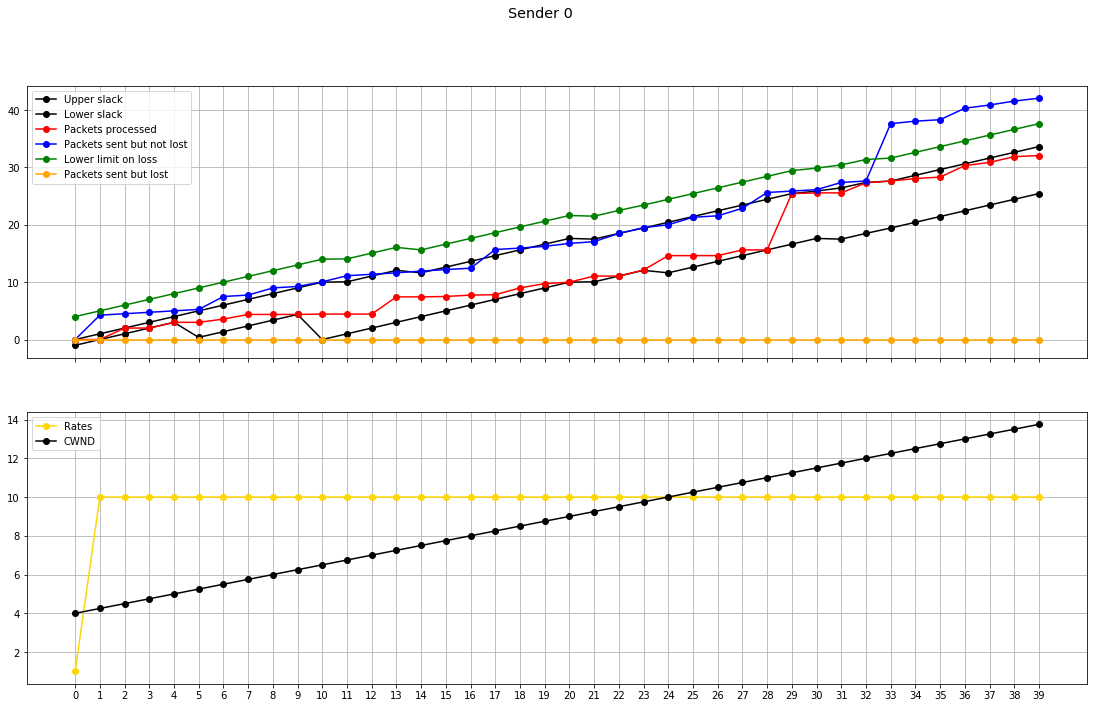

In [5]:
model.plot(sender_id=0)